#### 테스트를 위해 데이터 분리

In [1]:
## 분리해서 담을 폴더를 만듬
## 폴더명을 리스트로 만듬

import os

original_dataset_dir = './data/leaves_img_dataset/original_data/'
classes_list = os.listdir(original_dataset_dir)

base_dir = './data/leaves_img_dataset/splitted_data'
#os.mkdir(base_dir)

In [2]:
## 폴더명 리스트를 반복문을 활용해 각각 train,valid,test 폴더로 분리

import shutil

train_dir = os.path.join(base_dir, 'train')
#os.mkdir(train_dir)

validation_dir = os.path.join(base_dir, 'validation')
#os.mkdir(validation_dir)

test_dir = os.path.join(base_dir, 'test')
#os.mkdir(test_dir)
'''
for cls in classes_list:
    os.mkdir(os.path.join(train_dir, cls))
    os.mkdir(os.path.join(validation_dir, cls))
    os.mkdir(os.path.join(test_dir, cls))
''';

In [7]:
## 이미지를 위에 만들어 놓은 폴더에 담기
## train:valid:test == 6:2:2 비율

import math

for cls in classes_list:
    path = os.path.join(original_dataset_dir, cls)     # 이미지파일의 경로
    fnames = os.listdir(path)               # 이미지 파일의 이름 -> len하면 그 폴더의 이미지 전체 개수
    
    train_size = math.floor(len(fnames) * 0.6)         # 이미지 총 개수 * 0.6
    validation_size = math.floor(len(fnames) * 0.2)    # 이미지 총 개수 * 0.2
    test_size = math.floor(len(fnames) * 0.2)          # 이미지 총 개수 * 0.2
    
    train_fnames = fnames[:train_size]                 # 이미지 => [0:6]
    #print("Train size(",cls,"): ", len(train_fnames))
    for fname in train_fnames:                         # train 이미지 파일을 하나씩 train_dir에 복사
        src = os.path.join(path, fname)
        dst = os.path.join(os.path.join(train_dir, cls), fname)
        shutil.copyfile(src, dst)
        
    validation_fnames = fnames[train_size:(train_size + validation_size)] # 이미지 6 : 6 + 2 => [6:8]
    #print("Validation size(",cls,"): ", len(validation_fnames))
    for fname in validation_fnames:                    # train 이미지 파일을 하나씩 train_dir에 복사
        src = os.path.join(path, fname)
        dst = os.path.join(os.path.join(validation_dir, cls), fname)
        shutil.copyfile(src, dst)
        
    test_fnames = fnames[(train_size + validation_size):(train_size + validation_size + test_size)] # 이미지 6+2 : 6+2+2 => [8:10]
    #print("Test size(",cls,"): ", len(test_fnames))
    for fname in test_fnames:                    # train 이미지 파일을 하나씩 train_dir에 복사
        src = os.path.join(path, fname)
        dst = os.path.join(os.path.join(test_dir, cls), fname)
        shutil.copyfile(src, dst)

### torch 학습

In [3]:
import torch
import os

USE_CUDA = torch.cuda.is_available()
DEVICE = torch.device("cuda" if USE_CUDA else 'cpu')
print("Device is [",DEVICE,"]")

BATCH_SIZE = 256
EPOCH = 30

Device is [ cuda ]


In [4]:
import torchvision.transforms as transforms # resize / totensor
from torchvision.datasets import ImageFolder

# 폴더하나를 클래스로 매칭한다.... 폴더 이름을 라벨로 본다?
transform_base = transforms.Compose([transforms.Resize((64,64)), transforms.ToTensor()])
train_dataset = ImageFolder(root='./data/leaves_img_dataset/splitted_data/train', transform=transform_base)
val_dataset = ImageFolder(root='./data/leaves_img_dataset/splitted_data/validation', transform=transform_base)

In [5]:
## 데이터 읽기

from torch.utils.data import DataLoader

train_loader = torch.utils.data.DataLoader(train_dataset,
                                          batch_size=BATCH_SIZE,
                                          shuffle=True,
                                          num_workers=4)

val_loader = torch.utils.data.DataLoader(val_dataset,
                                          batch_size=BATCH_SIZE,
                                          shuffle=True,
                                          num_workers=4)

In [6]:
## 학습 구조 

import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

class Net(nn.Module):
    
    def __init__(self):
        
        super(Net, self).__init__()
        
        self.conv1 = nn.Conv2d(3, 32, 3, padding=1)
        self.pool = nn.MaxPool2d(2,2)
        self.conv2 = nn.Conv2d(32, 64, 3, padding=1)
        self.conv3 = nn.Conv2d(64, 64, 3, padding=1)

        self.fc1 = nn.Linear(4096, 512)
        self.fc2 = nn.Linear(512, 33)

    def forward(self, x):
        
        x = self.conv1(x)
        x = F.relu(x)
        x = self.pool(x)
        x = F.dropout(x, p=0.25, training=self.training) # 트레이닝에서만 사용한다?
        
        x = self.conv2(x)
        x = F.relu(x)
        x = self.pool(x)
        x = F.dropout(x, p=0.25, training=self.training)
        
        x = self.conv3(x)
        x = F.relu(x)
        x = self.pool(x)
        x = F.dropout(x, p=0.25, training=self.training)
        
        x = x.view(-1, 4096) # == flatten 과 같은 기능?
        x = self.fc1(x)
        x = F.relu(x)
        x = F.dropout(x, p=0.5, training=self.training)
        x = self.fc2(x)
        
        return F.log_softmax(x, dim=1)

In [7]:
## 모델/ 최적화 선언
model_base = Net().to(DEVICE)
optimizer = optim.Adam(model_base.parameters(), lr=0.001)

In [8]:
## 학습 시키는 함수 만들기

def train(model, train_loader, optimizer):
    model.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(DEVICE), target.to(DEVICE)
        optimizer.zero_grad()
        output = model(data)
        loss = F.cross_entropy(output, target)
        loss.backward()
        optimizer.step()

In [17]:
## 평가 함수

def evalulate(model, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    # 모델을 평가할때는 가중치업데이트가 되면 안된다.
    # no_grad : 기울기 업데이트 없게 하고 그 동안 for문으로 평가 해라
    with torch.no_grad(): # 어떤 자원을 사용하고 자동으로 멈춰줌 ex) usb open -> usb close
        for data, target in test_loader:
            data, target = data.to(DEVICE), target.to(DEVICE)
            output = model(data)
            
            test_loss += F.cross_entropy(output,target, reduction='sum').item()
            
            pred = output.max(1, keepdim=True)[1]
            correct += pred.eq(target.view_as(pred)).sum().item()
            
    test_loss /= len(test_loader.dataset)
    test_accuracy = 100. * correct / len(test_loader.dataset)
    return test_loss, test_accuracy

In [25]:
## 학습 시작?

import time
import copy

def train_baseline(model, train_loader, val_loader, optimizer, num_epochs = 30):
    from tqdm.notebook import tqdm

    best_acc = 0
    best_model_wts = copy.deepcopy(model.state_dict()) #정확도가 가장 높은 모델의 가중치
    
    for epoch in tqdm(range(1, num_epochs + 1)):
        since = time.time()
        train(model, train_loader, optimizer)
        train_loss, train_acc = evalulate(model, train_loader)
        val_loss, val_acc = evalulate(model, val_loader)
        
        if val_acc > best_acc:
            best_acc = val_acc
            best_model_wts = copy.deepcopy(model.state_dict())
            
        time_elapsed = time.time() - since
        print('----------------- epoch {} -----------------'.format(epoch))
        print('train Loss : {:.4f}, Accuracy : {:.2f}%'.format(train_loss, train_acc))
        print('val Loss : {:.4f}, Accuracy : {:.2f}%'.format(val_loss, val_acc))
        print('Completed in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
    
    model.load_state_dict(best_model_wts)
    return model
        
base = train_baseline(model=model_base,
                      train_loader=train_loader,
                      val_loader=val_loader,
                      optimizer=optimizer,
                      num_epochs=EPOCH)

torch.save(base,'14. base_model.pt')

  0%|          | 0/30 [00:00<?, ?it/s]

----------------- epoch 1 -----------------
train Loss : 0.9699, Accuracy : 71.11%
val Loss : 1.0098, Accuracy : 70.06%
Completed in 1m 31s
----------------- epoch 2 -----------------
train Loss : 0.6971, Accuracy : 78.12%
val Loss : 0.7513, Accuracy : 76.58%
Completed in 1m 43s
----------------- epoch 3 -----------------
train Loss : 0.5830, Accuracy : 81.98%
val Loss : 0.6427, Accuracy : 80.01%
Completed in 1m 35s
----------------- epoch 4 -----------------
train Loss : 0.4619, Accuracy : 86.01%
val Loss : 0.5323, Accuracy : 83.50%
Completed in 1m 31s
----------------- epoch 5 -----------------
train Loss : 0.4532, Accuracy : 85.69%
val Loss : 0.5293, Accuracy : 82.88%
Completed in 1m 31s
----------------- epoch 6 -----------------
train Loss : 0.3523, Accuracy : 89.65%
val Loss : 0.4333, Accuracy : 86.43%
Completed in 1m 32s
----------------- epoch 7 -----------------
train Loss : 0.3002, Accuracy : 91.17%
val Loss : 0.3828, Accuracy : 88.08%
Completed in 1m 31s
----------------- ep

## 저장했으니 불러와서 작업할때!!

In [7]:
## 모델 불러오기
## 학습 구조인 클래스를 같이 활성화 해주어야 에러없이 잘 불러온다.

import torch
import os
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

USE_CUDA = torch.cuda.is_available()
DEVICE = torch.device("cuda" if USE_CUDA else 'cpu')
print("Device is [",DEVICE,"]")

BATCH_SIZE = 256; EPOCH = 30

class Net(nn.Module):
    
    def __init__(self):
        
        super(Net, self).__init__()
        
        self.conv1 = nn.Conv2d(3, 32, 3, padding=1)
        self.pool = nn.MaxPool2d(2,2)
        self.conv2 = nn.Conv2d(32, 64, 3, padding=1)
        self.conv3 = nn.Conv2d(64, 64, 3, padding=1)

        self.fc1 = nn.Linear(4096, 512)
        self.fc2 = nn.Linear(512, 33)

    def forward(self, x):
        
        x = self.conv1(x)
        x = F.relu(x)
        x = self.pool(x)
        x = F.dropout(x, p=0.25, training=self.training) # 트레이닝에서만 사용한다?
        
        x = self.conv2(x)
        x = F.relu(x)
        x = self.pool(x)
        x = F.dropout(x, p=0.25, training=self.training)
        
        x = self.conv3(x)
        x = F.relu(x)
        x = self.pool(x)
        x = F.dropout(x, p=0.25, training=self.training)
        
        x = x.view(-1, 4096) # == flatten 과 같은 기능?
        x = self.fc1(x)
        x = F.relu(x)
        x = F.dropout(x, p=0.5, training=self.training)
        x = self.fc2(x)
        
        return F.log_softmax(x, dim=1)

base = torch.load("./14. base_model.pt", map_location=DEVICE)

Device is [ cuda ]


## 전이학습

전이학습(Transfer Learning)이란, 기존에 사전학습된(pre trained) 모델을 가져와, 사용하고자 하는 학습 데이터를 학습시켜 이용하는 방법으로, 기존에 비슷한 도메인의 데이터를 학습한 모델이라면 현재 갖고있는 데이터가 다소 적더라도 좋은 성능을 보여줄 수 있다.

가중치를 랜덤하게 학습하지 않고 따른 모델의 구조를 사용해 더 빠르게 학습하는 방법으로
특정레이어에서 결과를 바로 사용하거나, 가중치만 가져와서 학습에 사용하거나 할수 있다.

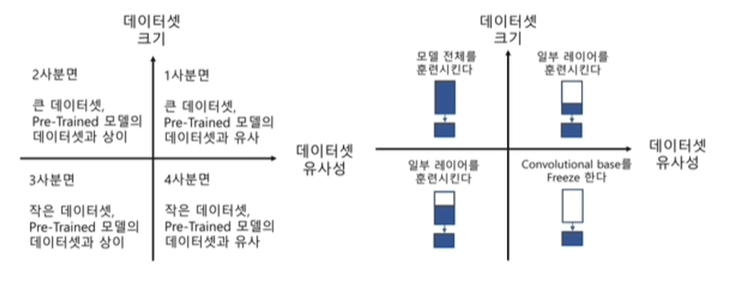

In [8]:
## 토치 이미지폴더 함수에 넣을 딕셔너리

## Compose는 전처리할때 사용 -> resize

## flip -> 상하좌우 반전해라 
## 반전 주는 이유 : 한가지 class를 한가지 포즈로만 학습하면 과적합 될수도 있어 방지용

## Crop -> 이미지를 무작위로 잘라냄 -> (52 * 52) 사이즈로

## Normalize -> RGB 색상값 (0~1)이라 가정할떄 [평균] [표준편차] 의 셋팅

data_transforms = {
    'train' : transforms.Compose([
           transforms.Resize([64,64]),
           transforms.RandomHorizontalFlip(), transforms.RandomVerticalFlip(),
           transforms.RandomCrop(52), transforms.ToTensor(),
           transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]) 
        ]),
    
    'validation' : transforms.Compose([
           transforms.Resize([64,64]),
           transforms.RandomHorizontalFlip(), transforms.RandomVerticalFlip(),
           transforms.RandomCrop(52), transforms.ToTensor(),
           transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]) 
        ])
}

In [10]:
## train과 validation 폴더의 이미지를 지정한 변환장치를 거쳐 이미지폴더로 저장해라

data_dir = './data/leaves_img_dataset/splitted_data'

image_datasets = {x : ImageFolder(root = os.path.join(data_dir, x),
                               transform = data_transforms[x]) for x in ['train', 'validation']}

data_loaders = {x : torch.utils.data.DataLoader(image_datasets[x],
                                                batch_size = BATCH_SIZE,
                                                shuffle = True,
                                                num_workers = 4) for x in ['train', 'validation']}
dataset_sizes = {x : len(image_datasets[x]) for x in ['train', 'validation']}

class_names = image_datasets['train'].classes

In [11]:
## 전이학습에 사용할 학습된 모델을 불러오기

# ------------- 이전 표현 -------------
#from torchvision import models
#resnet = models.resnet50(pretrained=True)  # true는 학습 가중치 가져옴, False는 구조만
# ------------- 이전 표현 -------------
# 새로운 방식 : https://pytorch.org/vision/stable/models.html

from torchvision.models import resnet50, ResNet50_Weights
resnet = resnet50(weights=ResNet50_Weights.DEFAULT)

        ##  resnet출력은 50이다 근데 우리모델은 33개로 잡아놨다. 
        ## 즉 , 마지막 fullyconnected 레이어를 50에서 33으로 바꿔줘야 한다.
num_ftrs = resnet.fc.in_features       # resnet50의 마지막 fc레이어의 피쳐를 불러오기
resnet.fc = nn.Linear(num_ftrs, 33)    # fc레이어를 nn리니어를 거쳐 33으로 다시 나오도록 바꿔주기
resnet = resnet.to(DEVICE)

criterion = nn.CrossEntropyLoss()

        # 원레 resnet모델의 가중치는 다 안다. 근데 마지막 fc레이어는 우리가 수정해서 가중치를 모른다.
        # 그래서 그것만 최적화 작업을 해라
optimizer_ft = optim.Adam(filter(lambda p : p.requires_grad, resnet.parameters()), lr=0.001)


        ## 에포크에 따라서 lr을 바꿔준다. lr을 step_size마다 gamma만큼 감소시킨다.
from torch.optim import lr_scheduler
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

- ### filter(조건 함수, 순회 가능한 데이터)
<br>
filter() 함수는 두 번째 인자로 넘어온 데이터 중에서 첫 번째 인자로 넘어온 조건 함수를 만족하는 데이터만 찾아서 반환해줍니다.

ex)
```python
filter(lambda x: x < 5, range(10))

=> [0, 1, 2, 3, 4]
```

In [12]:
## cildren : 모델에 속해있는 하위레이어들의 정보  

ct = 0
for child in resnet.children():
    ct += 1
    if ct < 6: # 입력단과 가까운 층 5개는 고정을 시킨다 (Freeze)
        for param in child.parameters():
            param.requires_grad = False

In [13]:
def train_resnet(model, criterion, optimizer, scheduler, num_epoch=25):
    from tqdm.notebook import tqdm; import time;
    
    # 처음에 resnet의 가중치 복사
    # 1 ~ 32는 그대로 33은 랜덤하게 잡혀있는 상태
    
    best_model_wts = copy.deepcopy(model.state_dict()) 
    best_acc = 0.0
    
    for epoch in tqdm(range(num_epoch)):
        print('----------------- epoch {} -----------------'.format(epoch+1))
        since = time.time()
        for phase in ['train', 'validation']:
            if phase == 'train':
                model.train()
            else:
                model.eval()
                
            running_loss = 0.0
            running_corrects = 0
            
            for inputs, labels in data_loaders[phase]:
                inputs = inputs.to(DEVICE)
                labels = labels.to(DEVICE)
                optimizer.zero_grad()
                
                ## train이라면 가중치 업데이트를 허가한다.
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1) #가장 높은 숫자 : 즉, 예측 결과
                    loss = criterion(outputs, labels)
                    
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()
                        
                running_loss += loss.item() * inputs.size(0) # 총 손실 = 손실 * batch_size
                running_corrects += torch.sum(preds == labels.data) # 예측이 맞는지
            if phase == 'train':
                scheduler.step()
                
            epoch_loss = running_loss/dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]
            
            print('{} Loss : {:.4f} Acc : {:.4f}'.format(phase, epoch_loss, epoch_acc))
            
            
            if phase == 'validation' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())
            
        time_elapsed = time.time() - since
        print('Completed in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
    print('Best validation Accuracy : {:.4}'.format(best_acc))
    
    model.load_state_dict(best_model_wts)
    
    return model

In [15]:
from tqdm.notebook import tqdm
import copy

model_resnet50 = train_resnet(model=resnet,
                             criterion=criterion,
                             optimizer=optimizer_ft,
                             scheduler=exp_lr_scheduler,
                             num_epoch=EPOCH)

torch.save(model_resnet50,'14. base_model(resnet50).pt')

  0%|          | 0/30 [00:00<?, ?it/s]

----------------- epoch 1 -----------------
train Loss : 0.5859 Acc : 0.8328
validation Loss : 0.1803 Acc : 0.9404
Completed in 1m 15s
----------------- epoch 2 -----------------
train Loss : 0.1225 Acc : 0.9594
validation Loss : 0.1350 Acc : 0.9556
Completed in 0m 27s
----------------- epoch 3 -----------------
train Loss : 0.0880 Acc : 0.9720
validation Loss : 0.1136 Acc : 0.9660
Completed in 0m 27s
----------------- epoch 4 -----------------
train Loss : 0.0744 Acc : 0.9754
validation Loss : 0.0959 Acc : 0.9692
Completed in 0m 28s
----------------- epoch 5 -----------------
train Loss : 0.0599 Acc : 0.9796
validation Loss : 0.0772 Acc : 0.9751
Completed in 0m 36s
----------------- epoch 6 -----------------
train Loss : 0.0537 Acc : 0.9819
validation Loss : 0.0801 Acc : 0.9777
Completed in 0m 29s
----------------- epoch 7 -----------------
train Loss : 0.0496 Acc : 0.9830
validation Loss : 0.0749 Acc : 0.9771
Completed in 0m 29s
----------------- epoch 8 -----------------
train Loss 

In [20]:
transform_resnet = transforms.Compose([
    transforms.Resize([64, 64]),
    transforms.RandomCrop(52),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

test_resnet = ImageFolder(root = './data/leaves_img_dataset/splitted_data/test/', transform=transform_resnet)
test_loader_resnet = torch.utils.data.DataLoader(test_resnet,
                                                batch_size=BATCH_SIZE,
                                                shuffle=True,
                                                num_workers=4)

In [21]:
resnet50 = torch.load('./14. base_model(resnet50).pt')
resnet50.eval()
test_loss, test_accuracy = evalulate(resnet50, test_loader_resnet)

print('Resnet test acc :', test_accuracy)

Resnet test acc : 99.06120916259857
